In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
import pickle
import os
import math
from ReferentialData.polygonData import PolygonAPI
from DataAnalysis.DataExtensions import *
from Filtering.KalmanFilter import KalmanFilter
import glob

Load Data

In [2]:
DIR = r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache'
root_dir = r'C:\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Histo'
COR_DIR = r'\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Clustering'

In [3]:
# Tickers to Load
UNIVERSE = list(pd.read_csv(os.path.join(root_dir, 'clean_names.csv'))['0'])
# UNIVERSE = ['AAPL']
## End Date
end_dt = "2025-01-01"
## Start date
start_dt = "2020-01-01"

In [4]:
colnames = ["Close", "Volume"]
DataLoader = PolygonAPI()
MID_LOADED = False
HIGH_LOADED = False
if not MID_LOADED:
    mid_df = {}
if not HIGH_LOADED:
    high_df = {}
# ### loading in low frequency data
# if len(mid_df) == 0:
#     mid_df = DataLoader.getPrices(UNIVERSE, "day", logDir=os.path.join(DIR,"Beta_Callibration"), _parallel=True)
#     MID_LOADED = True

### loading in high frequency data
if len(high_df) == 0:
    high_df = DataLoader.getPrices(UNIVERSE[:4], timespan="hour", 
                                   from_ = start_dt, 
                                   to_=end_dt, logDir=DIR, override=False, _parallel=True)
    HIGH_LOADED = True

In [7]:
high_df[0].keys()

dict_keys(['AVDV', 'ASHR', 'ARKW', 'AQWA'])

In [47]:
master_df = pd.DataFrame()
master_df = pd.concat(high_df[0].values())
master_df.sort_values('timestamp', inplace=True)
master_df
# for ticker in high_df[0]:
    # master_df = pd.concat([high_df[0][ticker], master_df])
# master_df

C:\Users\raymo\AppData\Local\Temp\ipykernel_17644\1434399724.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat(high_df[0].values())


,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,45.4000,45.4000,45.1300,45.1400,42667.0,45.1414,1579597200000,40,None
0,31.0400,31.0400,31.0400,31.0400,112.0,31.0400,1579597200000,1,None
0,16.8300,16.8300,16.8300,16.8300,200.0,16.8300,1579597200000,2,None
0,27.1700,27.3800,27.1500,27.3800,1700.0,27.2612,1579597200000,11,None
0,71.4700,71.4700,71.0100,71.0100,2415.0,71.1565,1579597200000,21,None
...,...,...,...,...,...,...,...,...,...
7059,0.3647,0.3647,0.3510,0.3605,1959.0,0.3590,1735689600000,7,None
19392,32.6700,32.7500,32.6500,32.6500,41557.0,32.6855,1735689600000,58,None
19888,220.8500,221.3500,220.8100,221.0000,4230.0,220.9738,1735689600000,77,None
19490,108.3500,108.4000,108.2200,108.3100,1801.0,108.3160,1735689600000,8,None


In [39]:
def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

daily_dt = 10e3*60*60*24
min_dt = 10e3*60
dt_ratio = daily_dt / min_dt 


def getTimeDiffs(dt_list: np.array):
    ## case to ms unix tyime
    if type(dt_list[0]) == np.datetime64:
        dt_list = get_unixtime(dt_list)
    shifted_dt = np.roll(dt_list, 1)
    res = dt_list - shifted_dt
    res[0] = 0 ## as this makes no sense
    return res

logReturnTransform = lambda df : np.log(df.loc[:,~df.columns.str.contains('timestamp')]) - np.log(df.loc[:,~df.columns.str.contains('timestamp')]).shift(1)
def logRetDtDailyTransform(df):
    return logReturnTransform(df.loc[:,~df.columns.str.contains('timestamp')]).apply(
        lambda col: np.asarray(col) / getTimeDiffs(np.asarray(df.index.values)) *math.sqrt(dt_ratio))


# Cross Sectional Analysis

### EOD vs EOW

{3840.0, 900.0, 3720.0, 780.0, 3600.0, 5400.0, 3480.0, 2460.0, 5280.0, 5160.0, 300.0, 180.0, 4020.0, 1080.0, 60.0, 3900.0, 960.0, 3780.0, nan, 840.0, 3660.0, 720.0, 2640.0, 3960.0, 600.0, 5340.0, 3420.0, 2400.0, 5220.0, 2280.0, 5100.0, 240.0, 4080.0, 120.0, 1020.0}


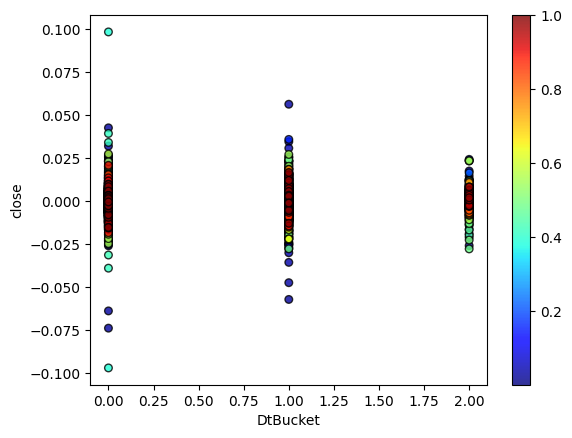

In [48]:
### Cross-Sectional Analysis 

### time delta indication that it's CLOSE - OPEN (standard day): 9am = 33:00, 4:30pm = 16:30
CLOSE_OPEN_DELTA = (33 - 16.5) * 60
### time delta indication that it's WEEKEND: CLOSE_OPEN_DELTA + 48 HRS
CLOSE_OPEN_WEEKEND_DELTA = CLOSE_OPEN_DELTA + 48 * 60

WeekdayDeltaMask = lambda dt: dt < CLOSE_OPEN_WEEKEND_DELTA and dt > CLOSE_OPEN_DELTA
WeekendDeltaMask = lambda dt: dt > CLOSE_OPEN_WEEKEND_DELTA

test = logReturnTransform(high_df[0]['ACWI'].drop('otc',axis=1))
test['timestamp'] = high_df[0]['ACWI']['timestamp']
test['TimeDelta'] =  (high_df[0]['ACWI']['timestamp'] - high_df[0]['ACWI']['timestamp'].shift(1)).values / (60 * 1000)
test['DtBucket'] = test.apply(lambda dr: int(WeekdayDeltaMask(dr['TimeDelta'])) + 2*int(WeekendDeltaMask(dr['TimeDelta'])), axis=1)
# test = test[test['TimeDelta'] > 1]
print(set(test['TimeDelta']))
scatterHeat('DtBucket', 'close', 'timestamp', test)

### WEEKDAY EOD ANALYSIS

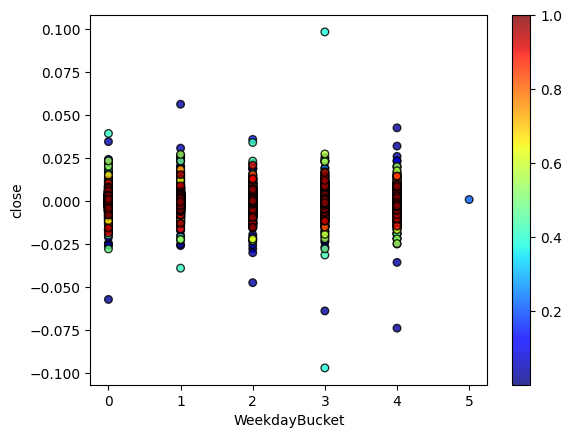

In [49]:
test['WeekdayBucket'] = [pd.to_datetime(date, unit='ms').weekday() for date in test['timestamp']]
scatterHeat('WeekdayBucket', 'close', 'timestamp', test)

C:\Users\raymo\AppData\Local\Temp\ipykernel_17644\3222618142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intra_test['WeekdayBucket'] = [pd.to_datetime(date, unit='ms').weekday() for date in intra_test['timestamp']]


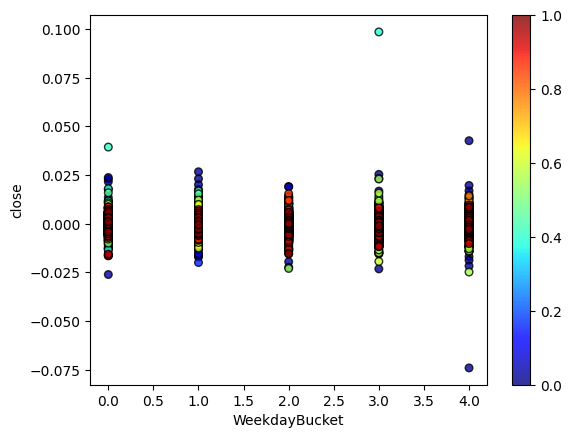

In [58]:
### intraday filter
intra_test = test[test['TimeDelta'] <= 60]
intra_test['WeekdayBucket'] = [pd.to_datetime(date, unit='ms').weekday() for date in intra_test['timestamp']]
# plt.scatter(intra_test['WeekdayBucket'], intra_test['close'])
scatterHeat('WeekdayBucket', 'close', 'timestamp', intra_test)

In [59]:
weekday_vol_summary = {}

from enum import Enum

class Weekday(Enum):
    MONDAY = 0
    TUESDAY = 1
    WEDNESDAY = 2
    THURSDAY = 3
    FRIDAY = 4
    SATURDAY = 5
    SUNDAY = 6

for i in range(0,6):
    weekday_df = intra_test[intra_test['WeekdayBucket']==i]
    weekday_vol_summary[Weekday(i)] = weekday_df['close'].describe()

pd.DataFrame(weekday_vol_summary).transpose()

,count,mean,std,min,25%,50%,75%,max
Weekday.MONDAY,1613.0,0.000134,0.003274,-0.026115,-0.000978,0.000127,0.001284,0.039339
Weekday.TUESDAY,1781.0,0.000003,0.003204,-0.019958,-0.001124,0.000097,0.001237,0.026668
Weekday.WEDNESDAY,1775.0,-0.000052,0.003230,-0.022995,-0.001306,0.000000,0.001275,0.019089
Weekday.THURSDAY,1755.0,-0.000041,0.004193,-0.023217,-0.001394,0.000044,0.001459,0.098488
Weekday.FRIDAY,1727.0,0.000052,0.003843,-0.074086,-0.001157,0.000125,0.001404,0.042615
Weekday.SATURDAY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


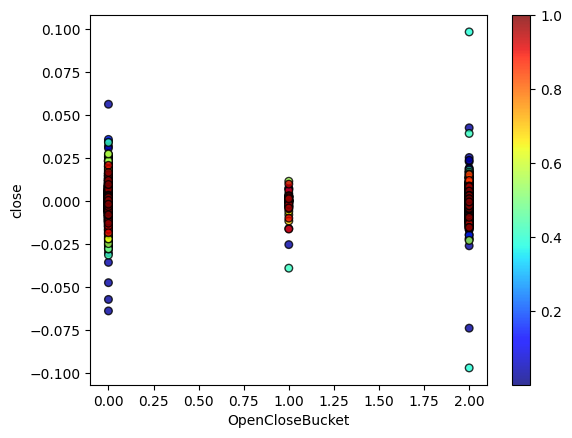

In [60]:
### intraday filter and end of day filter
test['OpenCloseBucket'] = [int(pd.to_datetime(date, unit='ms').hour < 10)
                               + 2 *int(pd.to_datetime(date, unit='ms').hour > 15) for date in test['timestamp']]
# plt.scatter(intra_test['OpenCloseBucket'], test['close'])
scatterHeat('OpenCloseBucket', 'close', 'timestamp', test)


C:\Users\raymo\AppData\Local\Temp\ipykernel_17644\2139268756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter_test['WeekdayBucket'] = [pd.to_datetime(date, unit='ms').weekday() for date in inter_test['timestamp']]


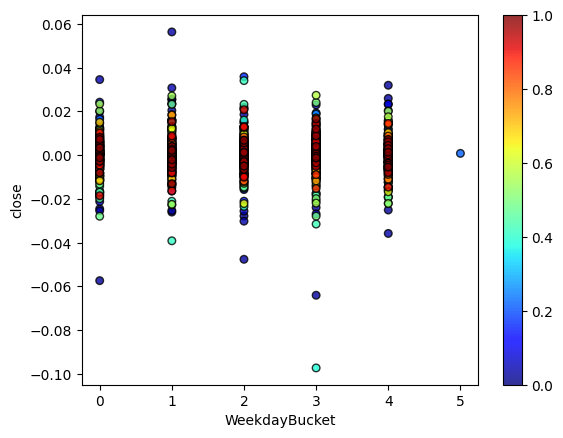

,count,mean,std,min,25%,50%,75%,max
Weekday.MONDAY,261.0,-0.000183,0.008724,-0.057354,-0.003358,0.000516,0.004122,0.034568
Weekday.TUESDAY,284.0,0.000442,0.008942,-0.039141,-0.003168,-0.000074,0.003070,0.056361
Weekday.WEDNESDAY,287.0,0.000487,0.008276,-0.047591,-0.002412,0.000783,0.004002,0.035866
Weekday.THURSDAY,287.0,-0.000017,0.010474,-0.097252,-0.002864,0.000378,0.004698,0.027396
Weekday.FRIDAY,273.0,0.000047,0.008076,-0.035767,-0.004440,0.000414,0.004287,0.031979
Weekday.SATURDAY,1.0,0.000836,NaN,0.000836,0.000836,0.000836,0.000836,0.000836


In [61]:
inter_test = test[test['TimeDelta'] > 60]
inter_test['WeekdayBucket'] = [pd.to_datetime(date, unit='ms').weekday() for date in inter_test['timestamp']]
# plt.scatter(intra_test['WeekdayBucket'], intra_test['close'])
scatterHeat('WeekdayBucket', 'close', 'timestamp', inter_test)
weekday_vol_summary = {}

from enum import Enum

class Weekday(Enum):
    MONDAY = 0
    TUESDAY = 1
    WEDNESDAY = 2
    THURSDAY = 3
    FRIDAY = 4
    SATURDAY = 5
    SUNDAY = 6

for i in range(0,6):
    weekday_df = inter_test[inter_test['WeekdayBucket']==i]
    weekday_vol_summary[Weekday(i)] = weekday_df['close'].describe()

pd.DataFrame(weekday_vol_summary).transpose()

In [62]:
weekday_vol_summary[Weekday(0)]/math.sqrt(2)

count    184.554870
mean      -0.000129
std        0.006168
min       -0.040555
25%       -0.002375
50%        0.000365
75%        0.002915
max        0.024443
Name: close, dtype: float64

In [63]:
### avg of intraday return
print('Intraday Avg Return:', intra_test['close'].mean())
print('Intraday Std Return:', intra_test['close'].std())

### avg of inteday return - not over weekend
print('Interday Avg Return:', inter_test[inter_test['WeekdayBucket'] != 0]['close'].mean())
print('Interday Std Return:', inter_test[inter_test['WeekdayBucket'] != 0]['close'].std())

### avg of inteday return - weekend
print('Weekend Avg Return:', inter_test[inter_test['WeekdayBucket'] == 0]['close'].mean())
print('Weekend Std Return:', inter_test[inter_test['WeekdayBucket'] == 0]['close'].std())

print('Avg Ratio of Intra to Daily Return', (inter_test[inter_test['WeekdayBucket'] != 0]['close'].mean() / 
      intra_test['close'].mean()
      ))

print('Std Ratio of Intra to Daily Return', (inter_test[inter_test['WeekdayBucket'] != 0]['close'].std()
      / intra_test['close'].std()
      )**2)


print('Avg Ratio of Intra to Daily Return', (inter_test[inter_test['WeekdayBucket'] == 0]['close'].mean() / 
      inter_test[inter_test['WeekdayBucket'] != 0]['close'].mean()
      ))

print('Std Ratio of Intra to Daily Return', (inter_test[inter_test['WeekdayBucket'] == 0]['close'].std() / 
      inter_test[inter_test['WeekdayBucket'] != 0]['close'].std()
      )**2)

Intraday Avg Return: 1.6932190804025022e-05
Intraday Std Return: 0.003573016160740097
Interday Avg Return: 0.00024208251374786949
Interday Std Return: 0.008989186725860127
Weekend Avg Return: -0.00018300484121006969
Weekend Std Return: 0.008723541127214006
Avg Ratio of Intra to Daily Return 14.297176103775245
Std Ratio of Intra to Daily Return 6.329520963169737
Avg Ratio of Intra to Daily Return -0.7559605953227602
Std Ratio of Intra to Daily Return 0.9417699355156415
